###### Using this Kaggle dataset: https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset/data

NOTE: This notebook assumes the data is structured as found in clean_data.ipynb

In [125]:
# -- IMPORTS --

import tensorflow as tf # ML.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pathlib # Easy file paths.
import numpy as np # Math.
import time # Performance measuring.

from sklearn.metrics import confusion_matrix

import seaborn as sns
import random
import collections
import math

import matplotlib.pyplot as plt # Plotting.
import matplotlib.cm as cm

In [20]:
# -- BASIC CONFIG --

# See clean_data.ipynb for expected structure.
DATA_DIR = pathlib.Path('data') #
TRAIN_DIR = DATA_DIR / 'train'
VALIDATE_DIR = DATA_DIR / 'validate'
TEST_DIR = DATA_DIR / 'test'
BLOOD_CELLS = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
for blood_cell in BLOOD_CELLS:
    train_folder_cell = TRAIN_DIR / blood_cell
    assert train_folder_cell.exists(), f"ERROR: Could not find {train_folder_cell}"

    validate_folder_cell = VALIDATE_DIR / blood_cell
    assert validate_folder_cell.exists(), f"ERROR: Could not find {validate_folder_cell}"

    test_folder_cell = TEST_DIR / blood_cell
    assert test_folder_cell.exists(), f"ERROR: Could not find {test_folder_cell}"

# Original image dimensions are 360 x 363 - decrease to save memory if needed.
IMG_WIDTH = 360 
IMG_HEIGHT = 363

BATCH_SIZE = 32 # Increase to save time but use more RAM, decrease to save RAM but take more time.
EPOCHS = 30 # Adjust as needed.

# Set random seed for reproducibility.
RAND_SEED = 42

In [21]:
# -- DATA LOADING  --

print("Loading datasets...")
start_time_data_load = time.time()

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    seed=RAND_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATE_DIR,
    label_mode='categorical',
    seed=RAND_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    shuffle=False, # Don't shuffle test set so evaluations are consistent.
    seed=RAND_SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

CLASS_NAMES = train_dataset.class_names
assert set(CLASS_NAMES) == set(BLOOD_CELLS), f"ERROR: could not find all classes when loading data (found: {CLASS_NAMES}, expected: {BLOOD_CELLS}"
NUM_CLASSES = len(CLASS_NAMES)

print(f"Found the following {len(CLASS_NAMES)} classes in {time.time() - start_time_data_load:.2f} seconds: {CLASS_NAMES}")

Loading datasets...
Found 13309 files belonging to 8 classes.
Found 1671 files belonging to 8 classes.
Found 1659 files belonging to 8 classes.
Found the following 8 classes in 0.63 seconds: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


In [22]:
# -- PERFORMANCE OPTIMIZATION --
# Remove if not working.

# Lets TensorFlow find best settings automatically.
AUTOTUNE = tf.data.AUTOTUNE 

# Cache() keeps images in memory after first epoch - improves performance if dataset can fit in RAM.
# Prefetch() overlaps data preprocessing and model execution.
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Configured dataset pipeline with caching and prefetching.")

Configured dataset pipeline with caching and prefetching.


In [23]:
# -- BUILDING CNN --

# Add random flips, rotations, zooms, brightness, and contrast to images to make the model more robust.
data_augmentation = Sequential(
    [
        layers.RandomFlip(
            "horizontal_and_vertical",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        ),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ],
    name="data_augmentation"
)

# Main model.
model = Sequential([
    # Rescale pixel values from [0, 255] to [0, 1].
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    data_augmentation,

    # Convolutional Block 1.
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 2.
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 3.
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the results to feed into Dense layers.
    layers.Flatten(),
    
    # Dense Layer.
    layers.Dense(128, activation='relu'),
    # Dropout for regularization (helps prevent overfitting).
    layers.Dropout(0.5),
    
    # Output Layer: NUM_CLASSES units, softmax for probability distribution.
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 363, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 363, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 363, 360, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 181, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 181, 180, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      33,177,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,272,008 (126.92 MB)

 Trainable params: 33,272,008 (126.92 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# -- TRAINING CNN --

# Stops training early if validation loss doesn't improve for 5 consecutive epochs.
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

print("\nStarting CNN training...")
start_time_training = time.time()

history = model.fit(
    train_dataset,
    validation_data=validate_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopper]
)

print(f"Finished training in {(time.time() - start_time_training)/60:.2f} minutes.")


Starting CNN training...
Epoch 1/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.3829 - loss: 2.0100 - val_accuracy: 0.7415 - val_loss: 0.6847
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.6979 - loss: 0.7863 - val_accuracy: 0.8115 - val_loss: 0.5049
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.7834 - loss: 0.5981 - val_accuracy: 0.8911 - val_loss: 0.3411
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.8225 - loss: 0.5039 - val_accuracy: 0.8947 - val_loss: 0.3015
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 407s 977ms/step - accuracy: 0.8362 - loss: 0.4617 - val_accuracy: 0.9132 - val_loss: 0.2517
Epoch 6/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 400s 962ms/step - accuracy: 0.8595 - loss: 0.4124 - val_accuracy: 0.9001 - val_loss: 0.2813
Epoch 7/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 399s 959ms/step - accuracy: 0.8639 - loss: 0.3850 - val_accuracy: 0.9252 - val_loss: 0.2081
Epoch 8/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 398s 957ms/step - accu

In [25]:
# -- EVALUATING CNN --

loss, accuracy = model.evaluate(test_dataset)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9601 - loss: 0.1152
Test loss: 0.1144
Test accuracy: 0.9602


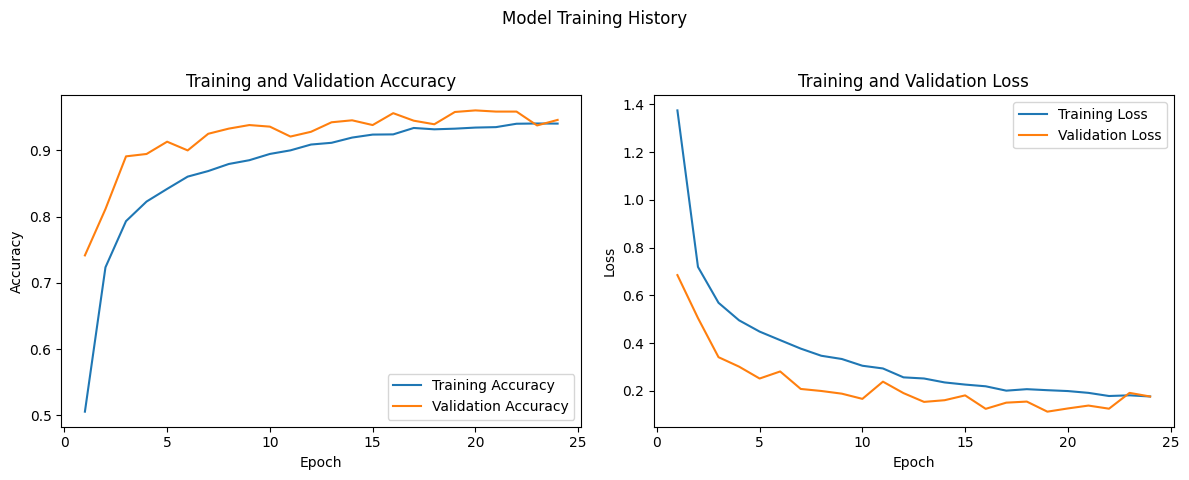

In [31]:
## -- EVALUATION VISUALIZATION --

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle("Model Training History")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


In [30]:
# -- SAVE THE MODEL FOR LATER USE --

# Save in multiple formats just in case.
model.save('blood_cell_classifier_cnn.h5')
model.save_weights('blood_cell_classifier_weights.weights.h5')
model.save('blood_cell_classifier_cnn.keras')
model.export('blood_cell_classifier_cnn')

INFO:tensorflow:Assets written to: blood_cell_classifier_cnn\assets


INFO:tensorflow:Assets written to: blood_cell_classifier_cnn\assets


Saved artifact at 'blood_cell_classifier_cnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 363, 360, 3), dtype=tf.float32, name='keras_tensor_105')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2229456731408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2229456727376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2229456727760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2229456727952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2229456726992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230092383632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230092384784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230092396304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230145861008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230145860432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2230145861776: Tensor

Generating predictions on the test set...
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step
Extracting true labels from the test set...
Using class names: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Displaying Confusion Matrix...


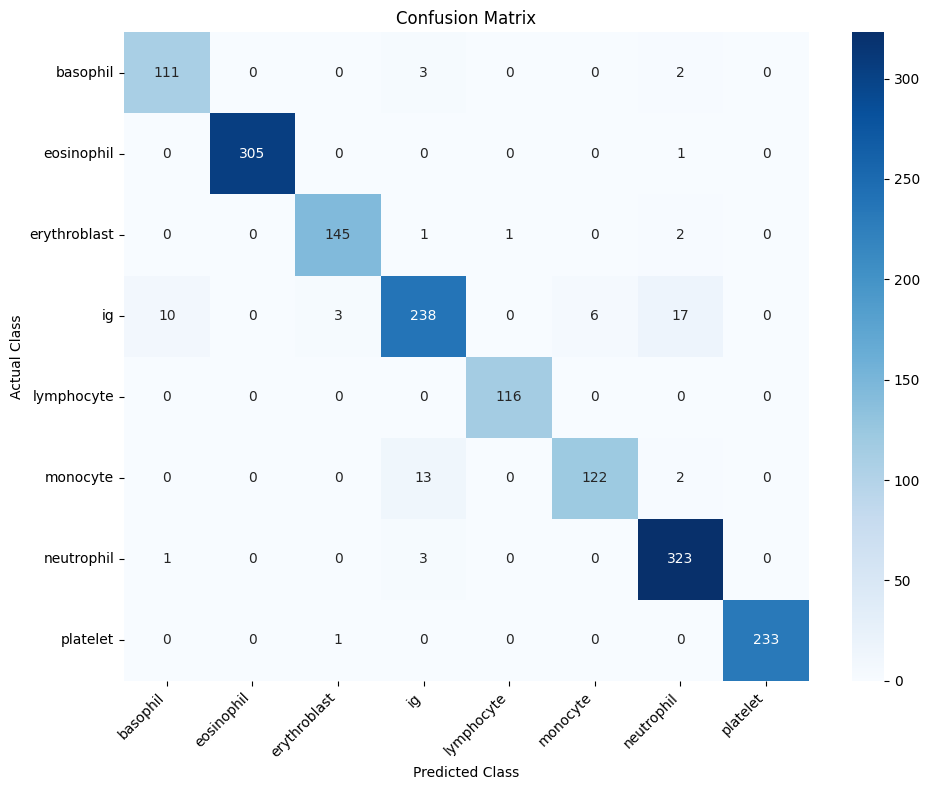

In [38]:
# -- CONFUSION MATRIX --

print("Generating predictions on the test set...")
# Get the predicted probabilities for the test set
y_pred_probs = model.predict(test_dataset)
# Convert probabilities to predicted class indices (0 to NUM_CLASSES-1)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

print("Extracting true labels from the test set...")
# Get the true labels (one-hot encoded) from the test dataset
y_true_one_hot = np.concatenate([y for x, y in test_dataset], axis=0)
# Convert one-hot encoded labels to true class indices
y_true_indices = np.argmax(y_true_one_hot, axis=1)

# --- COMPUTE CONFUSION MATRIX ---
# Class names should be available from the data loading step
# If not, redefine: CLASS_NAMES = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
print(f"Using class names: {CLASS_NAMES}")

cm = confusion_matrix(y_true_indices, y_pred_indices)

# --- DISPLAY CONFUSION MATRIX ---
print("Displaying Confusion Matrix...")
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
# -- GRAD-CAM HELPERS --

def make_gradcam_heatmap(img_array, model_name, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Args:
        img_array: Preprocessed input image array (with batch dimension).
        model: Trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer.
        pred_index: Index of the class for which to generate the map.
                    If None, the highest scoring class will be used.

    Returns:
        Heatmap array (without batch dimension).
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        #[model_name.inputs], [model_name.get_layer(last_conv_layer_name).output, model_name.layers[-1].output]
        model_name.input, [model_name.get_layer(last_conv_layer_name).output, model_name.layers[-1].output]
    )

    # Use GradientTape to compute the gradient of the top predicted class
    # (or specified class) with regard to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0]) # Get index of the highest probability class
        class_channel = preds[:, pred_index] # Get the score for that class

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0] # Remove batch dim
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap) # Remove channel dim

    # For visualization purpose, apply ReLU and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [89]:
# -- REMOVE DATA AUGMENTATION LAYER FROM MODEL --

print("Rebuilding model without augmentation and copying weights...")

# --- Define the architecture using NEW layer instances ---
input_tensor = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image_rebuilt")

# Mirror the layers from the original model, creating NEW instances
# Use configurations identical to the original model.summary()
x = layers.Rescaling(1./255, name='rescaling_rebuilt')(input_tensor)
# Skip augmentation layer

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_3_rebuilt')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3_rebuilt')(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_4_rebuilt')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_4_rebuilt')(x)

# Ensure the target conv layer has a predictable name if needed later, or use index
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_5_rebuilt')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_5_rebuilt')(x)

x = layers.Flatten(name='flatten_1_rebuilt')(x)
x = layers.Dense(128, activation='relu', name='dense_2_rebuilt')(x)
x = layers.Dropout(0.5, name='dropout_1_rebuilt')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='dense_3_rebuilt')(x) # Use NUM_CLASSES

# Create the new model instance
model_no_aug = tf.keras.Model(inputs=input_tensor, outputs=outputs, name="cnn_no_augmentation_rebuilt")

# --- Copy Weights from the original 'model' ---
print("Copying weights from original model...")
skipped_augmentation = False
target_layer_idx = 0 # Index for layers in model_no_aug (starts after Input)

for source_layer in model.layers:
    # Skip the Input layer implicitly created for Sequential 'model' if it exists
    # Also skip the data augmentation layer itself
    if isinstance(source_layer, tf.keras.layers.InputLayer) or source_layer.name == 'data_augmentation':
        if source_layer.name == 'data_augmentation':
            skipped_augmentation = True
            print(f"  Skipping weights for: {source_layer.name} (Data Augmentation)")
        continue

    # Get the corresponding layer in the rebuilt model
    # We need to be careful with indexing because we skipped layers
    if target_layer_idx >= len(model_no_aug.layers) -1: # -1 because target skips Input layer
         print(f"Warning: Ran out of target layers while processing source layer {source_layer.name}")
         break
    target_layer = model_no_aug.layers[target_layer_idx + 1] # +1 to skip Input in target

    if source_layer.get_weights(): # Check if the source layer has weights
         if len(source_layer.get_weights()) == len(target_layer.get_weights()):
             try:
                 target_layer.set_weights(source_layer.get_weights())
                 # print(f"  Copied weights from '{source_layer.name}' to '{target_layer.name}'")
             except ValueError as e:
                 print(f"  ERROR copying weights from '{source_layer.name}' to '{target_layer.name}': {e}")
         else:
             print(f"  WARNING: Weight list length mismatch for '{source_layer.name}' ({len(source_layer.get_weights())}) and '{target_layer.name}' ({len(target_layer.get_weights())}). Skipping weight copy.")
         target_layer_idx += 1 # Increment target index only if weights were potentially copied
    else:
        # If source layer has no weights (e.g., Pooling, Flatten, maybe Dropout), still advance target index
        target_layer_idx += 1

if not skipped_augmentation:
    print("WARNING: Did not find and skip the 'data_augmentation' layer during weight copy. Check layer names.")

print("\nModel without augmentation (rebuilt layers) created and weights copied.")
model_no_aug.summary() # Verify the structure

Rebuilding model without augmentation and copying weights...
Copying weights from original model...
  Skipping weights for: data_augmentation (Data Augmentation)

Model without augmentation (rebuilt layers) created and weights copied.


Model: "cnn_no_augmentation_rebuilt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image_rebuilt (InputLayer)     │ (None, 363, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_rebuilt (Rescaling)        │ (None, 363, 360, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3_rebuilt (Conv2D)            │ (None, 363, 360, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_3_rebuilt (MaxPooling2D)     │ (None, 181, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4_rebuilt (Conv2D)            │ (None, 181, 180, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_4_rebuilt (MaxPooling2D)     │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5_rebuilt (Conv2D)            │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_5_rebuilt (MaxPooling2D)     │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1_rebuilt (Flatten)          │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2_rebuilt (Dense)              │ (None, 128)                 │      33,177,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1_rebuilt (Dropout)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_rebuilt (Dense)              │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,272,008 (126.92 MB)

 Trainable params: 33,272,008 (126.92 MB)

 Non-trainable params: 0 (0.00 B)

Loading all test images and labels into memory...
Loaded 1659 test images in 1.02 seconds.
Grouped image indices by class.

Processing class: basophil (Index: 0)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  True Class: basophil
  Predicted Class: basophil (Confidence: 1.00)

Processing class: eosinophil (Index: 1)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  True Class: eosinophil
  Predicted Class: eosinophil (Confidence: 0.99)

Processing class: erythroblast (Index: 2)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
  True Class: erythroblast
  Predicted Class: erythroblast (Confidence: 1.00)

Processing class: ig (Index: 3)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
  True Class: ig
  Predicted Class: ig (Confidence: 1.00)

Processing class: lymphocyte (Index: 4)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
  True Class: lymphocyte
  Predicted Class: lymphocyte (Confidence: 1.00)

Processing class: monocyte (Index: 5)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
  True Class: monocyte
  Predicted Class:

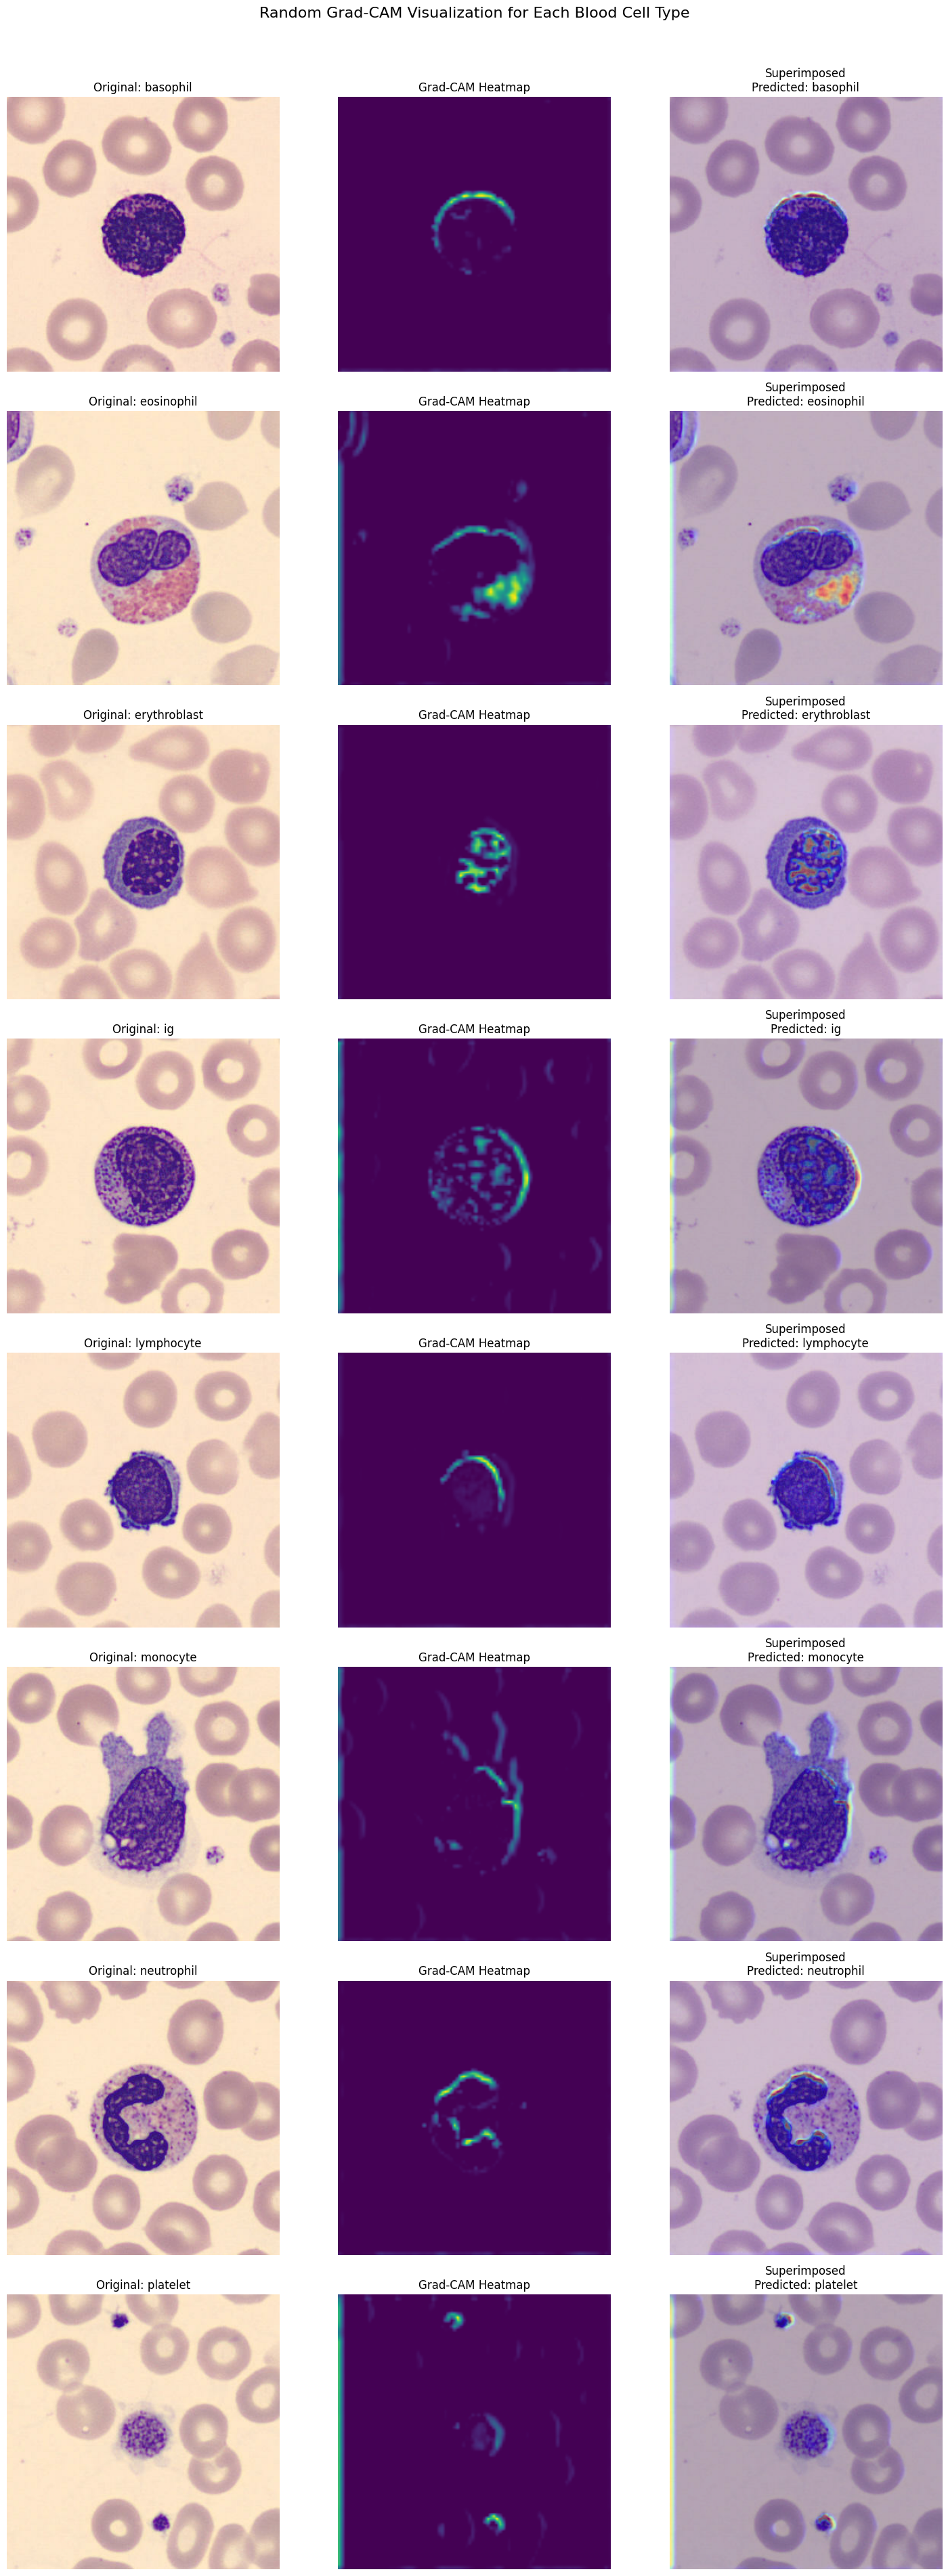

In [122]:
# --- Find one sample image for each class ---

last_conv_layer_name = "conv2d_5_rebuilt"

# --- Load ALL test images and labels into memory ---
print("Loading all test images and labels into memory...")
start_load_time = time.time()
all_test_images = []
all_test_labels_indices = []

# Iterate through the entire test dataset
# Make sure test_dataset was created with shuffle=False for consistency if needed later,
# although for random sampling it doesn't strictly matter here.
for images, labels in test_dataset:
    all_test_images.append(images.numpy()) # Add batch of images
    all_test_labels_indices.append(np.argmax(labels.numpy(), axis=1)) # Add batch of label indices

# Concatenate batches into single arrays
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels_indices = np.concatenate(all_test_labels_indices, axis=0)

print(f"Loaded {len(all_test_images)} test images in {time.time() - start_load_time:.2f} seconds.")

# --- Group image indices by class ---
images_by_class = {i: [] for i in range(NUM_CLASSES)}
for idx, label_index in enumerate(all_test_labels_indices):
    images_by_class[label_index].append(idx)

print("Grouped image indices by class.")

# --- Select random images, Generate and Display Grad-CAM ---

# Create figure for subplots
fig, axs = plt.subplots(NUM_CLASSES, 3, figsize=(15, NUM_CLASSES * 5)) # Width=15, Height=5 per class
plt.suptitle("Random Grad-CAM Visualization for Each Blood Cell Type", fontsize=16)

for class_index in range(NUM_CLASSES): # Loop through all possible classes 0 to N-1
    class_name = CLASS_NAMES[class_index]
    print(f"\nProcessing class: {class_name} (Index: {class_index})...")

    if not images_by_class[class_index]:
        print(f"  Warning: No images found for class '{class_name}' in the loaded test set.")
        # Optionally clear or mark the subplot row for this missing class
        axs[class_index, 0].set_title(f"{class_name}\n(No images found)")
        axs[class_index, 0].axis('off')
        axs[class_index, 1].axis('off')
        axs[class_index, 2].axis('off')
        continue # Skip to the next class

    # --- Select a RANDOM image for this class ---
    random_image_overall_index = random.choice(images_by_class[class_index])
    sample_image = all_test_images[random_image_overall_index]
    # We already know the true class index is 'class_index'
    true_class_name = class_name

    # --- Generate Predictions and Heatmap ---
    # Prepare input for the model (convert back to tensor if needed, add batch dim)
    img_tensor = tf.convert_to_tensor(sample_image, dtype=tf.float32)
    img_array = tf.expand_dims(img_tensor, axis=0)

    # Use ORIGINAL model for prediction text
    preds = model.predict(img_array)
    predicted_class_index = np.argmax(preds[0])
    predicted_class_name = CLASS_NAMES[predicted_class_index]
    prediction_confidence = np.max(preds[0])

    print(f"  True Class: {true_class_name}")
    print(f"  Predicted Class: {predicted_class_name} (Confidence: {prediction_confidence:.2f})")

    # Generate heatmap using model_no_aug for the predicted class
    heatmap = make_gradcam_heatmap(img_array, model_no_aug, last_conv_layer_name, pred_index=predicted_class_index)

    # --- Prepare for Display ---
    # Cast the selected numpy image to uint8 for display
    display_image = tf.cast(img_tensor, dtype=tf.uint8).numpy() # Use the tensor before batch dim

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], [IMG_HEIGHT, IMG_WIDTH]).numpy()
    heatmap_resized_squeezed = np.squeeze(heatmap_resized)

    jet = plt.colormaps["jet"]
    jet_colors = jet(heatmap_resized_squeezed)[:, :, 0:3]
    jet_heatmap = tf.keras.utils.array_to_img(jet_colors)
    jet_heatmap = jet_heatmap.resize((display_image.shape[1], display_image.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + display_image
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # --- Plot this class's results ---
    row = class_index

    # Original Image
    axs[row, 0].imshow(display_image)
    axs[row, 0].set_title(f"Original: {true_class_name}")
    axs[row, 0].axis('off')

    # Heatmap
    axs[row, 1].imshow(heatmap_resized_squeezed, cmap='viridis')
    axs[row, 1].set_title("Grad-CAM Heatmap")
    axs[row, 1].axis('off')

    # Superimposed Image
    axs[row, 2].imshow(superimposed_img)
    axs[row, 2].set_title(f"Superimposed\nPredicted: {predicted_class_name}")
    axs[row, 2].axis('off')

# Adjust layout and show
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Generating predictions for all test images...
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step
Generated predictions in 11.19 seconds.
Identifying misclassified examples...
Found 66 total misclassified images.

Preparing to visualize 4 common misclassification types...

Processing Error: True='ig', Predicted='neutrophil'
  Displaying example image index: 578

Processing Error: True='monocyte', Predicted='ig'
  Displaying example image index: 965

Processing Error: True='ig', Predicted='basophil'
  Displaying example image index: 645

Processing Error: True='ig', Predicted='monocyte'
  Displaying example image index: 694


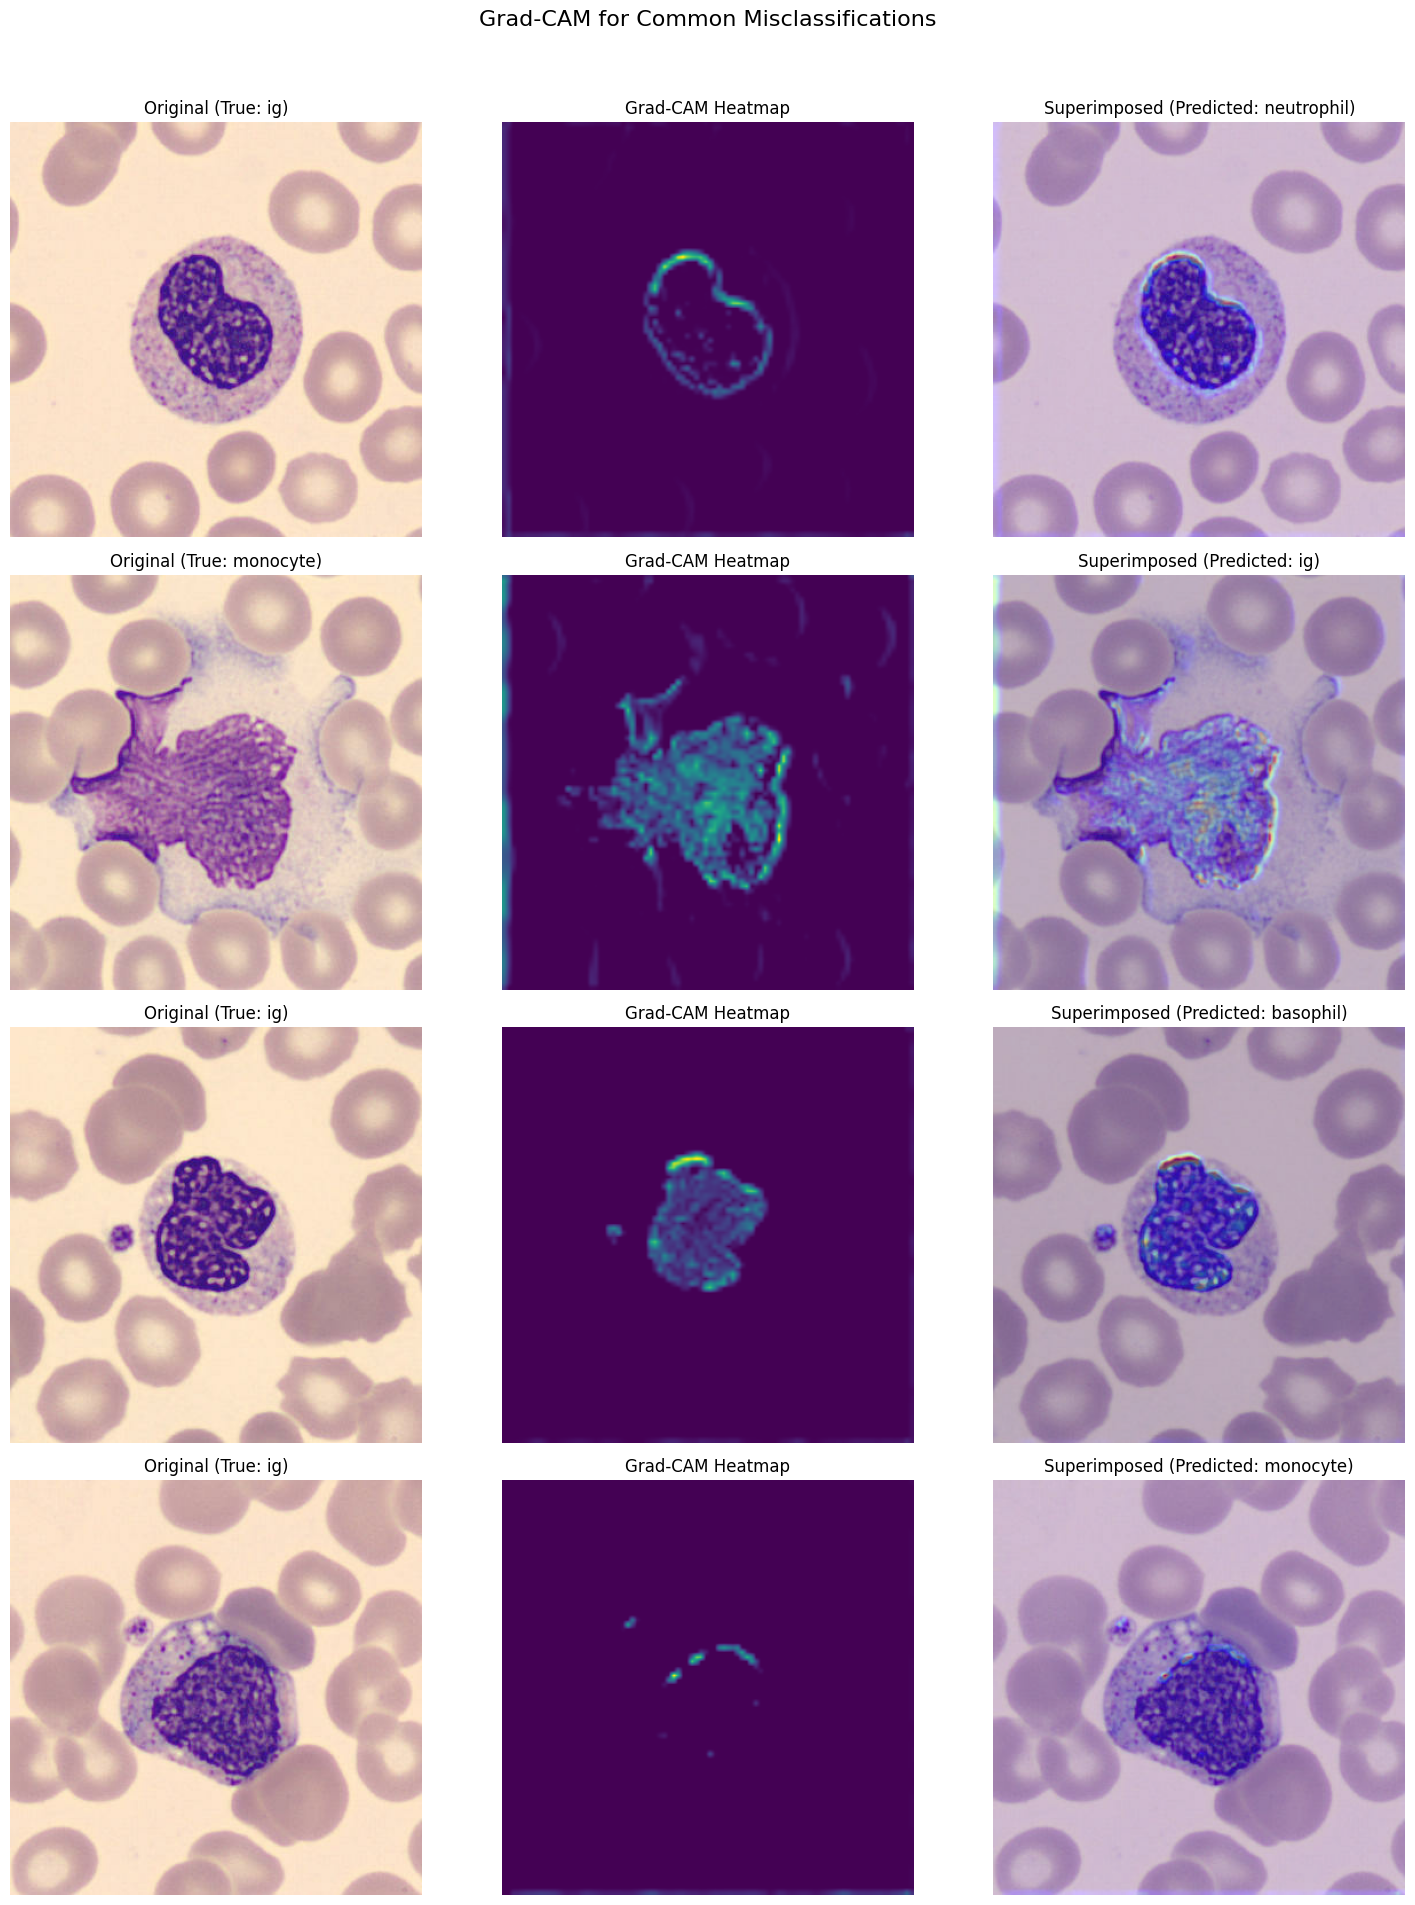

In [117]:
# -- Incorrect Grad-CAM Images --

# --- Get Predictions for ALL Test Images (More Efficient) ---
print("Generating predictions for all test images...")
start_pred_time = time.time()
# Use the ORIGINAL model for getting predictions
all_predictions = model.predict(all_test_images, batch_size=BATCH_SIZE) # Use original batch size
all_predicted_indices = np.argmax(all_predictions, axis=1)
print(f"Generated predictions in {time.time() - start_pred_time:.2f} seconds.")

# --- Find and Group Misclassified Examples ---
print("Identifying misclassified examples...")
misclassified_examples = collections.defaultdict(list) # Key: (true_idx, pred_idx), Value: list of image indices
misclassification_count = 0
for i in range(len(all_test_images)):
    true_idx = all_test_labels_indices[i]
    pred_idx = all_predicted_indices[i]
    if true_idx != pred_idx:
        misclassified_examples[(true_idx, pred_idx)].append(i)
        misclassification_count += 1
print(f"Found {misclassification_count} total misclassified images.")

# --- Define Common Errors to Visualize (Based on Confusion Matrix) ---
# Get indices from class names:
ig_idx = CLASS_NAMES.index('ig')
neutrophil_idx = CLASS_NAMES.index('neutrophil')
monocyte_idx = CLASS_NAMES.index('monocyte')
basophil_idx = CLASS_NAMES.index('basophil')

# List of (true_idx, pred_idx) tuples for the errors we want to see
errors_to_show = [
    (ig_idx, neutrophil_idx),  # Actual ig, Predicted neutrophil
    (monocyte_idx, ig_idx),  # Actual monocyte, Predicted ig
    (ig_idx, basophil_idx),  # Actual ig, Predicted basophil
    (ig_idx, monocyte_idx),  # Actual ig, Predicted monocyte
    # Add more pairs here if desired, e.g., (basophil_idx, ig_idx)
]

# Filter out error types for which we have no examples
errors_available = [err for err in errors_to_show if err in misclassified_examples]
num_errors_to_plot = len(errors_available)

if num_errors_to_plot == 0:
    print("\nNo examples found for the specified common misclassification types.")
else:
    print(f"\nPreparing to visualize {num_errors_to_plot} common misclassification types...")
    # --- Generate and Display Grad-CAM for one example of each error type ---
    fig, axs = plt.subplots(num_errors_to_plot, 3, figsize=(15, num_errors_to_plot * 5))
    # Handle case where num_errors_to_plot is 1 (axs will be 1D)
    if num_errors_to_plot == 1:
        axs = np.expand_dims(axs, axis=0)

    plt.suptitle("Grad-CAM for Common Misclassifications", fontsize=16)

    plot_row_idx = 0
    for true_idx, pred_idx in errors_available:
        print(f"\nProcessing Error: True='{CLASS_NAMES[true_idx]}', Predicted='{CLASS_NAMES[pred_idx]}'")

        # Get the list of image indices for this specific error
        indices_for_this_error = misclassified_examples[(true_idx, pred_idx)]

        # Select the first example found for this error type
        image_index = indices_for_this_error[0]
        sample_image = all_test_images[image_index]
        true_class_name = CLASS_NAMES[true_idx]
        predicted_class_name = CLASS_NAMES[pred_idx] # Already know this from the key

        print(f"  Displaying example image index: {image_index}")

        # --- Generate Heatmap ---
        img_tensor = tf.convert_to_tensor(sample_image, dtype=tf.float32)
        img_array = tf.expand_dims(img_tensor, axis=0)

        # Generate heatmap using model_no_aug for the *predicted* class
        heatmap = make_gradcam_heatmap(img_array, model_no_aug, last_conv_layer_name, pred_index=pred_idx)

        # --- Prepare for Display ---
        display_image = tf.cast(img_tensor, dtype=tf.uint8).numpy()
        heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], [IMG_HEIGHT, IMG_WIDTH]).numpy()
        heatmap_resized_squeezed = np.squeeze(heatmap_resized)

        jet = plt.colormaps["jet"]
        jet_colors = jet(heatmap_resized_squeezed)[:, :, 0:3]
        jet_heatmap = tf.keras.utils.array_to_img(jet_colors)
        jet_heatmap = jet_heatmap.resize((display_image.shape[1], display_image.shape[0]))
        jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 0.4 + display_image
        superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

        # --- Plot this example ---
        # Original Image
        axs[plot_row_idx, 0].imshow(display_image)
        axs[plot_row_idx, 0].set_title(f"Original (True: {true_class_name})")
        axs[plot_row_idx, 0].axis('off')

        # Heatmap
        axs[plot_row_idx, 1].imshow(heatmap_resized_squeezed, cmap='viridis')
        axs[plot_row_idx, 1].set_title("Grad-CAM Heatmap")
        axs[plot_row_idx, 1].axis('off')

        # Superimposed Image
        axs[plot_row_idx, 2].imshow(superimposed_img)
        axs[plot_row_idx, 2].set_title(f"Superimposed (Predicted: {predicted_class_name})")
        axs[plot_row_idx, 2].axis('off')

        plot_row_idx += 1 # Move to the next row for the next error type

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust rect for suptitle
    plt.show()

Activation model created.

Selected Image Index: 150, True Class: eosinophil
Running prediction on activation model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Received 3 activation outputs.
Displaying feature maps...
  Layer 'conv2d_3_rebuilt': 32 filters, map size 363x360, plotting grid 6x6


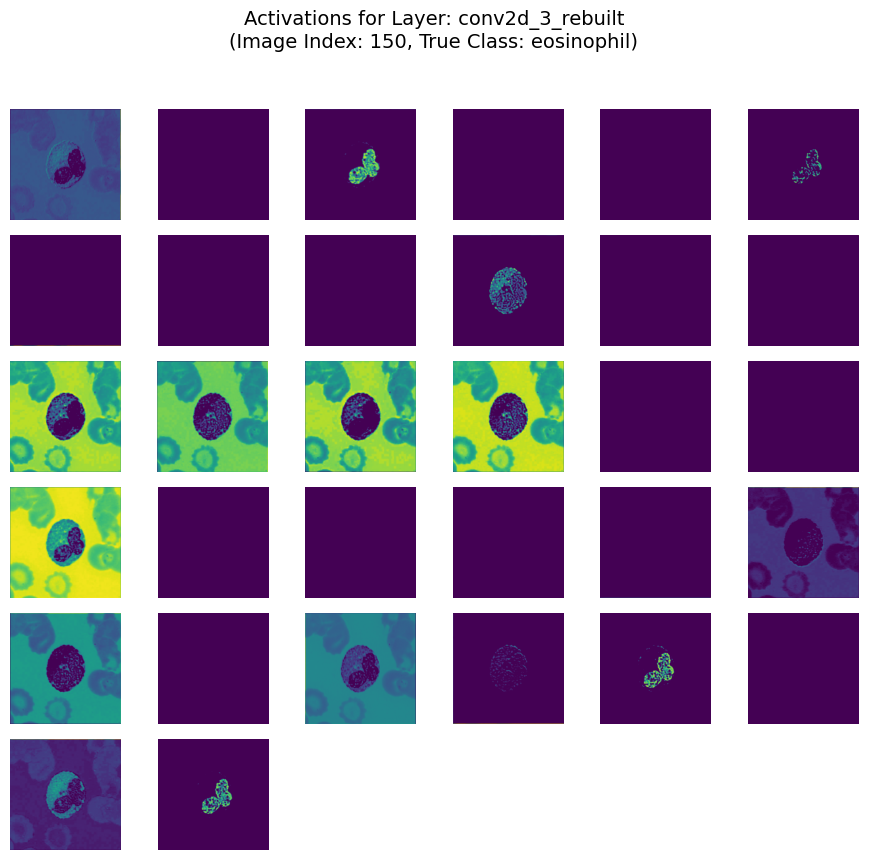

  Layer 'conv2d_4_rebuilt': 64 filters, map size 181x180, plotting grid 8x8


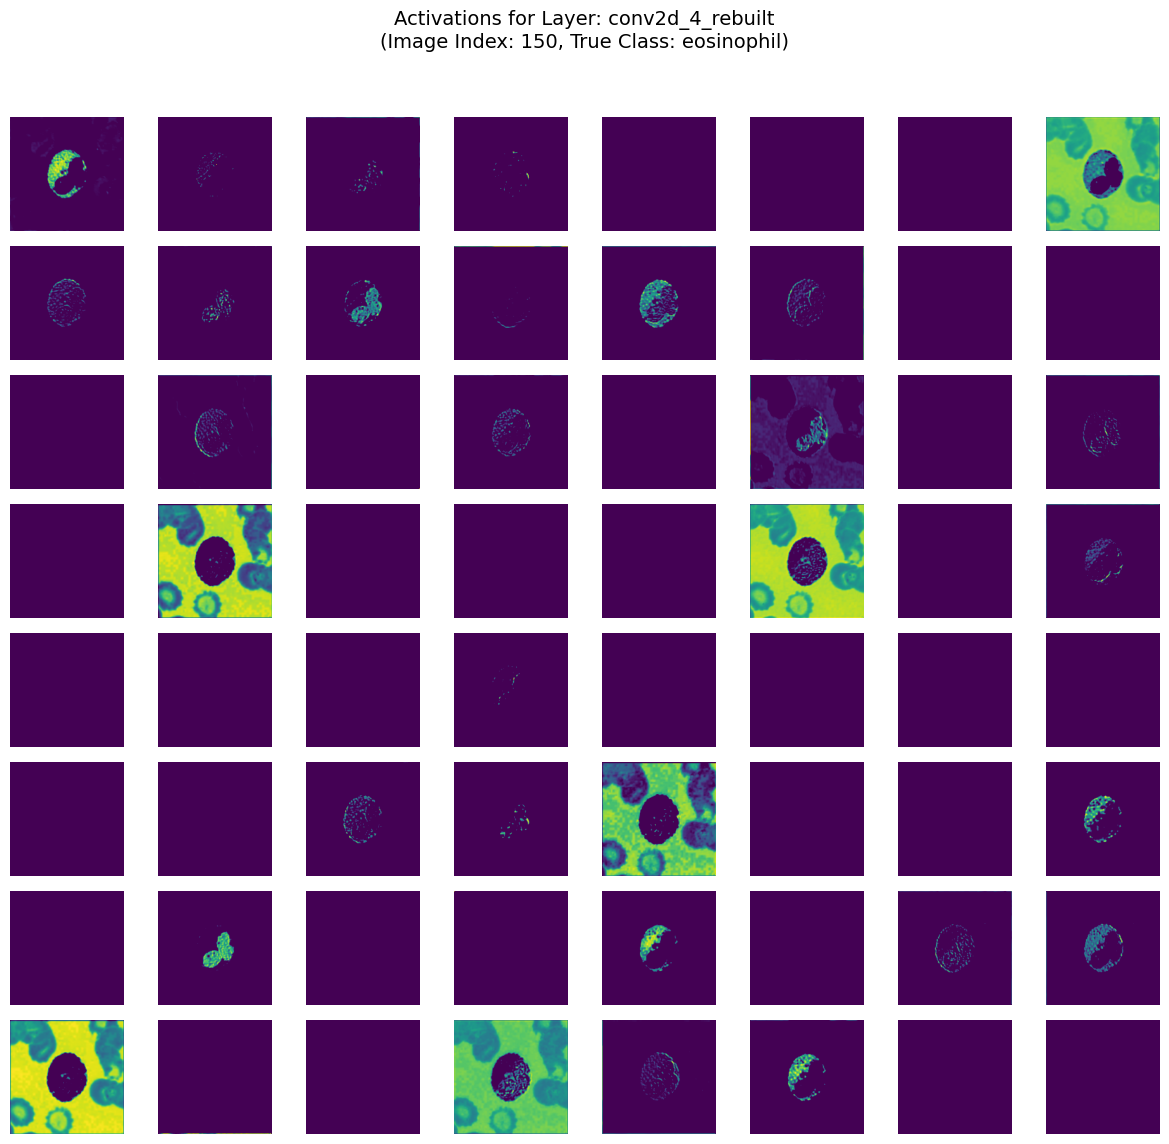

  Layer 'conv2d_5_rebuilt': 128 filters, map size 90x90, plotting grid 11x12


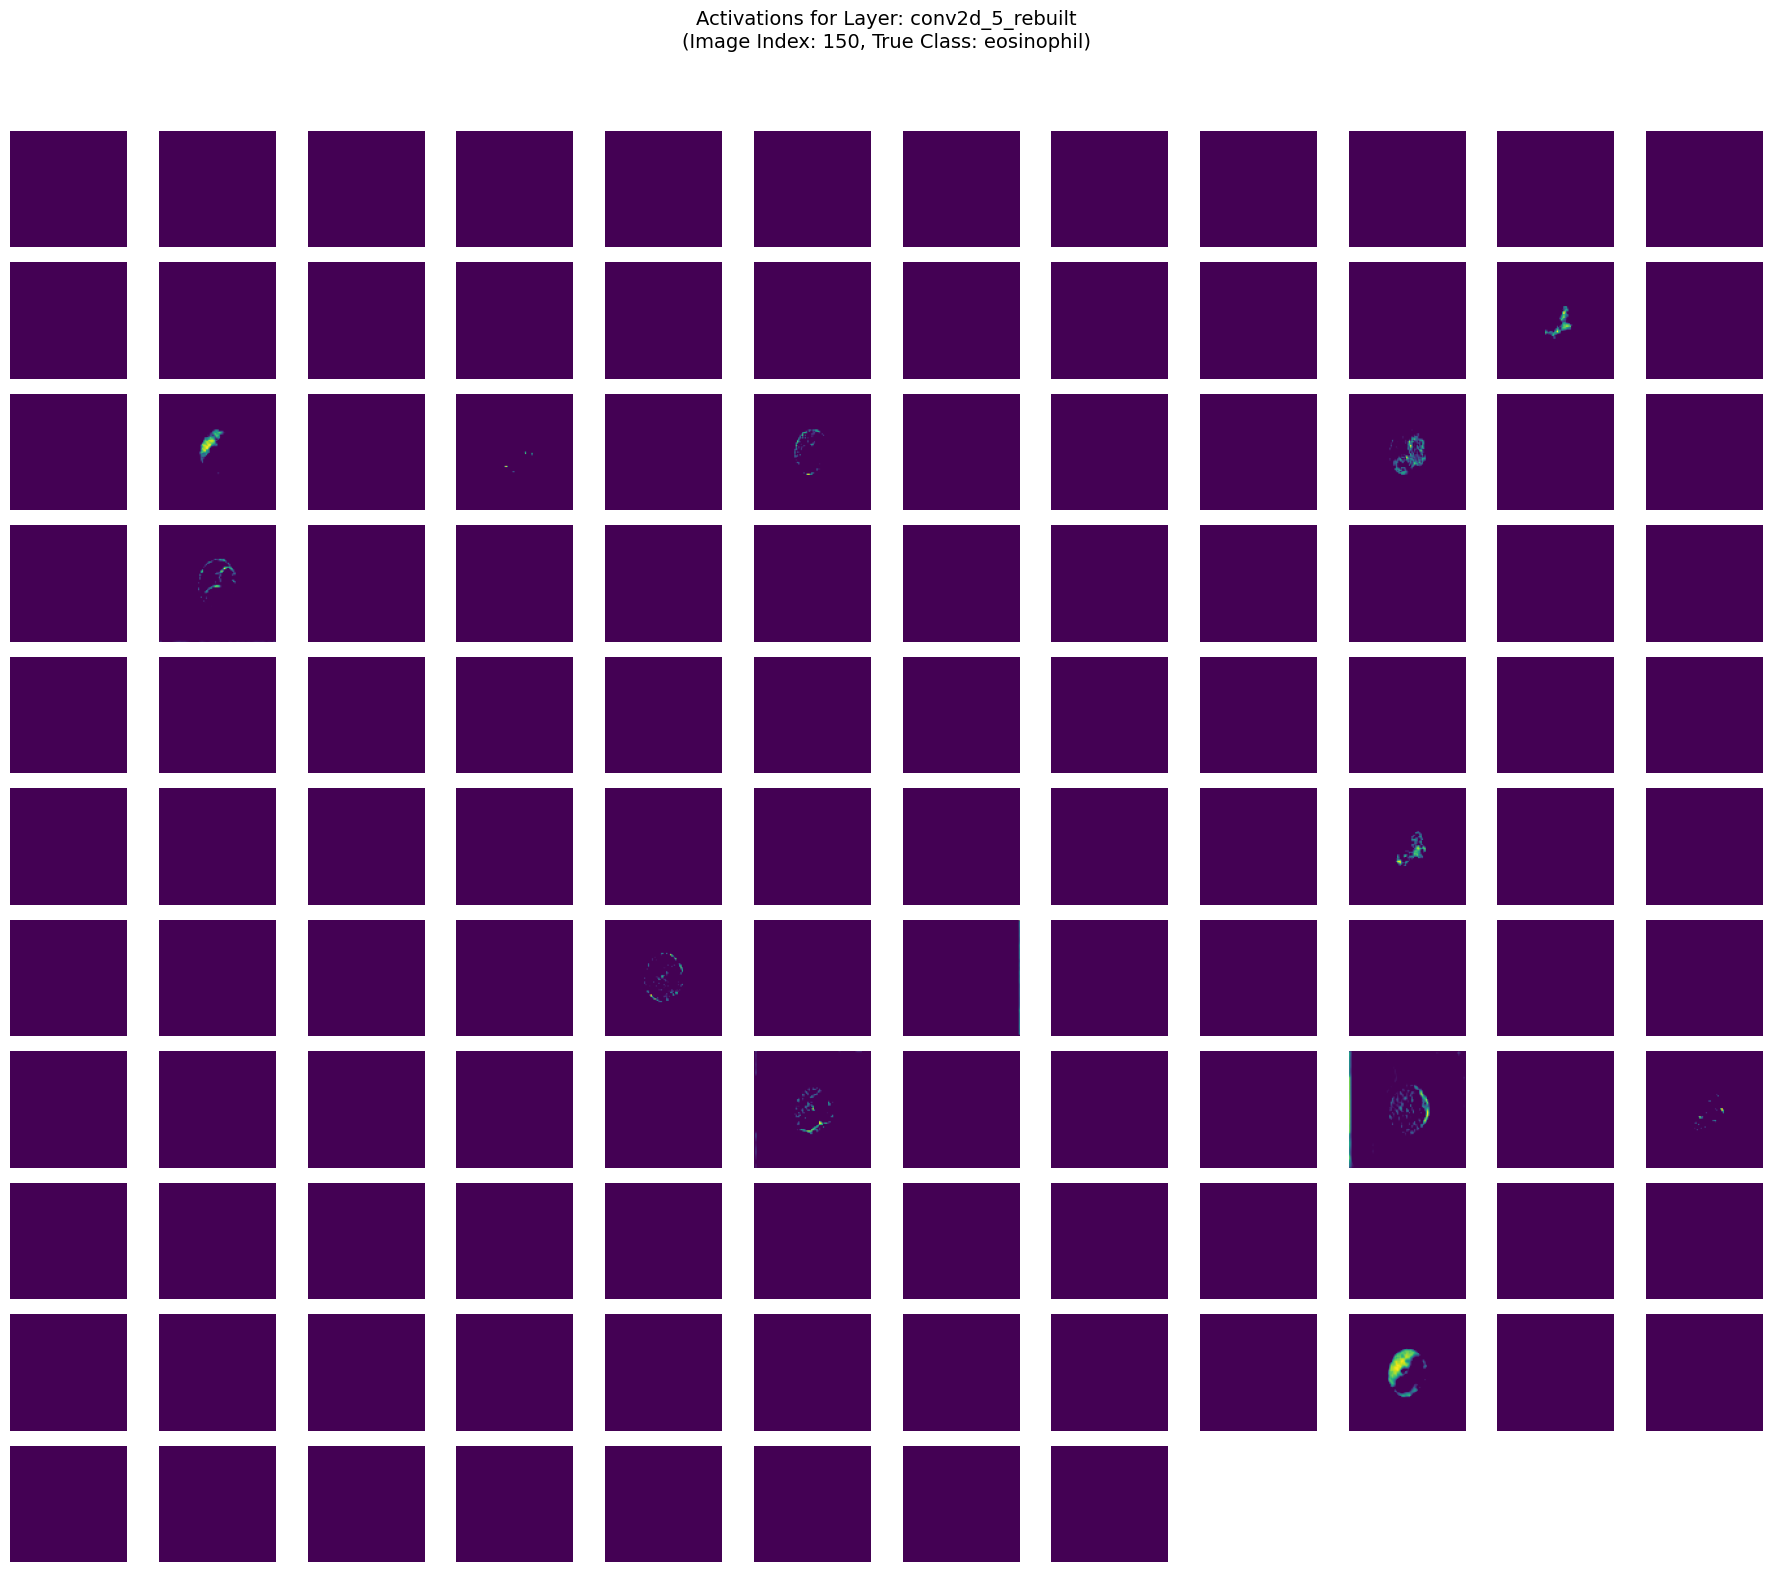

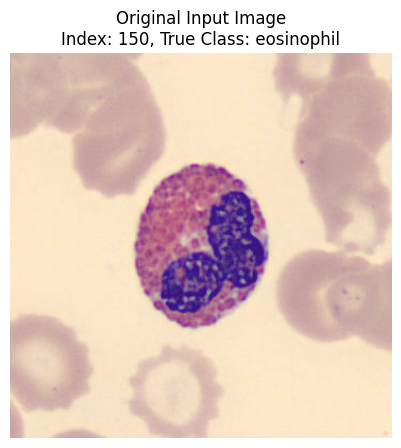

In [135]:
# --- Select Layers to Visualize ---
layer_names = [
    'conv2d_3_rebuilt',
    'conv2d_4_rebuilt',
    'conv2d_5_rebuilt'
    # Add or remove layer names (from model_no_aug.summary()) as desired
]
layers_to_visualize = [model_no_aug.get_layer(name).output for name in layer_names]

# --- Create the Activation Model ---
# Takes the same input as model_no_aug
# Outputs the activations from the selected layers
activation_model = tf.keras.Model(inputs=model_no_aug.input, outputs=layers_to_visualize)

print("Activation model created.")

# --- Select a Sample Image ---
# Option 1: Choose a specific class (e.g., Eosinophil)
target_class_name_analyze = 'eosinophil' # Or choose another class
target_class_index_analyze = CLASS_NAMES.index(target_class_name_analyze)
if not images_by_class[target_class_index_analyze]:
     print(f"Error: No images found for the target class '{target_class_name_analyze}'")
     # Handle error or choose a different class
else:
    # Option 1a: Pick the first one found
    # image_overall_index = images_by_class[target_class_index_analyze][0]
    # Option 1b: Pick randomly
    image_overall_index = random.choice(images_by_class[target_class_index_analyze])

    sample_image_np = all_test_images[image_overall_index]
    true_class_name = CLASS_NAMES[all_test_labels_indices[image_overall_index]]
    print(f"\nSelected Image Index: {image_overall_index}, True Class: {true_class_name}")

    # Prepare image for the model
    img_tensor = tf.convert_to_tensor(sample_image_np, dtype=tf.float32)
    img_array = tf.expand_dims(img_tensor, axis=0) # Add batch dimension

    # --- Get Activations ---
    print("Running prediction on activation model...")
    activations = activation_model.predict(img_array)
    print(f"Received {len(activations)} activation outputs.")

    # --- Visualize the Feature Maps ---
    print("Displaying feature maps...")
    display_image = tf.cast(img_tensor, dtype=tf.uint8).numpy()

    for layer_name, layer_activation in zip(layer_names, activations):
        if len(layer_activation.shape) != 4:
             print(f"Skipping layer {layer_name}, unexpected activation shape: {layer_activation.shape}")
             continue

        n_features = layer_activation.shape[-1]  # Number of filters (channels)
        size_h = layer_activation.shape[1]       # Height of feature map
        size_w = layer_activation.shape[2]       # Width of feature map

        # Calculate grid size for plotting filters
        n_cols = int(math.ceil(math.sqrt(n_features)))
        n_rows = int(math.ceil(n_features / n_cols))

        print(f"  Layer '{layer_name}': {n_features} filters, map size {size_h}x{size_w}, plotting grid {n_rows}x{n_cols}")

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5)) # Adjust figsize as needed
        fig.suptitle(f"Activations for Layer: {layer_name}\n(Image Index: {image_overall_index}, True Class: {true_class_name})", fontsize=14)


        # Plot each filter's activation map
        for i in range(n_features):
            row = i // n_cols
            col = i % n_cols
            channel_image = layer_activation[0, :, :, i] # Get the i-th filter map for the first (only) image in batch

            # Post-process for better visualization (optional normalization)
            # channel_image -= channel_image.mean()
            # channel_image /= (channel_image.std() + 1e-5) # Add epsilon to prevent div by zero
            # channel_image *= 64
            # channel_image += 128
            # channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Select the correct subplot (handling 1D/2D axs array)
            current_ax = None
            if n_rows == 1 and n_cols == 1:
                 current_ax = axs
            elif n_rows == 1:
                 current_ax = axs[col]
            elif n_cols == 1:
                 current_ax = axs[row]
            else:
                 current_ax = axs[row, col]

            current_ax.imshow(channel_image, cmap='viridis') # 'viridis' is good for activations
            current_ax.axis('off')
            # current_ax.set_title(f"Filter {i}") # Optional: title each filter

        # Turn off axes for any remaining empty subplots
        for i in range(n_features, n_rows * n_cols):
             row = i // n_cols
             col = i % n_cols
             current_ax = None
             if n_rows == 1 and n_cols == 1:
                  # Should not happen if n_features > 1
                  pass
             elif n_rows == 1:
                  current_ax = axs[col]
             elif n_cols == 1:
                  current_ax = axs[row]
             else:
                  current_ax = axs[row, col]
             if current_ax is not None:
                 current_ax.axis('off')


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
        plt.show() # Show plot for the current layer before moving to the next

# Display the original image for reference
plt.figure(figsize=(5,5))
plt.imshow(display_image)
plt.title(f"Original Input Image\nIndex: {image_overall_index}, True Class: {true_class_name}")
plt.axis('off')
plt.show()